In [1]:
import data_loader
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn import tree
%matplotlib inline


# 0. Loading the data

In [2]:
init_train = data_loader.load_train_data("../data/adult.data", valid_rate=1, is_df = "True")
test = data_loader.load_test_data("../data/adult.test", is_df = "True")
train = init_train[1]

# 1. Data preprocessing

## Replacing all column indices with attribute names

We printed the dataframe and we noticed that column values were numbers, so we replaced with the attribute names for better readability.

In [3]:
col_map = ["age", "workclass", "final_weight", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "cap_gain", "cap_loss", "hrs_p_week","country","income"]
train.columns = col_map
test.columns = col_map

## Printing train and test data

In [4]:
train.head()

,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hrs_p_week,country,income
24337,62,Local-gov,68268,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
17049,50,Private,215990,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
21016,36,Private,185405,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,>50K
2790,64,Private,258006,Some-college,10,Widowed,Adm-clerical,Not-in-family,White,Female,0,0,40,Cuba,<=50K
13511,28,Self-emp-not-inc,39388,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,60,United-States,<=50K


In [5]:
test.head()

,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hrs_p_week,country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


It seems that in test data, the income class has a '.' at the end. Remove it in data cleaning phase

## Columns in the data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 24337 to 10137
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
final_weight      32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
cap_gain          32561 non-null int64
cap_loss          32561 non-null int64
hrs_p_week        32561 non-null int64
country           32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


## Converting other columns to categorical for both train and test data

In [7]:
train = pd.concat([
        train.select_dtypes(['object']).apply(pd.Series.astype, dtype = 'category'),
        train.select_dtypes([], ['object'])
        ], axis = 1).reindex(train.columns, axis = 1)

test = pd.concat([
        test.select_dtypes(['object']).apply(pd.Series.astype, dtype = 'category'),
        test.select_dtypes([],['object'])
        ], axis = 1).reindex(test.columns, axis = 1)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 24337 to 10137
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null category
final_weight      32561 non-null int64
education         32561 non-null category
education_num     32561 non-null int64
marital_status    32561 non-null category
occupation        32561 non-null category
relationship      32561 non-null category
race              32561 non-null category
sex               32561 non-null category
cap_gain          32561 non-null int64
cap_loss          32561 non-null int64
hrs_p_week        32561 non-null int64
country           32561 non-null category
income            32561 non-null category
dtypes: category(9), int64(6)
memory usage: 2.0 MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null category
final_weight      16281 non-null int64
education         16281 non-null category
education_num     16281 non-null int64
marital_status    16281 non-null category
occupation        16281 non-null category
relationship      16281 non-null category
race              16281 non-null category
sex               16281 non-null category
cap_gain          16281 non-null int64
cap_loss          16281 non-null int64
hrs_p_week        16281 non-null int64
country           16281 non-null category
income            16281 non-null category
dtypes: category(9), int64(6)
memory usage: 910.7 KB


## Summary of numerical data

### Training data

In [10]:
train.describe()

,age,final_weight,education_num,cap_gain,cap_loss,hrs_p_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### Test data

In [11]:
test.describe()

,age,final_weight,education_num,cap_gain,cap_loss,hrs_p_week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


## Checking if numerical columns are correlated

In [12]:
print(train.corr())

                    age  final_weight  education_num  cap_gain  cap_loss  \
age            1.000000     -0.076646       0.036527  0.077674  0.057775   
final_weight  -0.076646      1.000000      -0.043195  0.000432 -0.010252   
education_num  0.036527     -0.043195       1.000000  0.122630  0.079923   
cap_gain       0.077674      0.000432       0.122630  1.000000 -0.031615   
cap_loss       0.057775     -0.010252       0.079923 -0.031615  1.000000   
hrs_p_week     0.068756     -0.018768       0.148123  0.078409  0.054256   

               hrs_p_week  
age              0.068756  
final_weight    -0.018768  
education_num    0.148123  
cap_gain         0.078409  
cap_loss         0.054256  
hrs_p_week       1.000000  


As none of the numerical columns in the training data are correlated, we cannot drop any of them.

# 2. Data cleaning

## Removing the . at the end of income class in test data

In [13]:
test["income"] = test["income"].map(lambda x:x.rstrip('.'))

In [14]:
test.head()

,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hrs_p_week,country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Also, every categorical data entry has a space at the beginning(for both train and test data)

## Removing space from data

In [15]:
for col in train.columns:
    if(train[col].dtype != "int64"):
        train[col] = train[col].map(lambda x:x.lstrip(' '))
        
for col in test.columns:
    if(test[col].dtype != "int64"):
        test[col] = test[col].map(lambda x:x.lstrip(' '))

## Removing missing Values
We now noticed that the training dataset had missing values and we counted the no of missing values for every column. After finding out the columns that missing values, we removed those corresponding rows. It was approximately around 2000 and did not alter the dataset much.

### No of missing rows per column in training data

In [16]:
for column in train.columns:
    su = (train[column] == '?').sum()
    if su > 0:
        print("Column: ", column, " Count of ?: ",su)

Column:  workclass  Count of ?:  1836
Column:  occupation  Count of ?:  1843
Column:  country  Count of ?:  583


C:\Users\Karan\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### Removing the rows with missing entries

In [17]:
train = train[((train.country != '?') & (train.workclass != '?') & (train.occupation != '?'))]

In [18]:
print(train.workclass.value_counts())

Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Never-worked            0
?                       0
Name: workclass, dtype: int64


### No of missing rows per column in test data

In [19]:
for column in test.columns:
    su = (test[column] == '?').sum()
    if su > 0:
        print("Column: ",column, " Count of ?: ",su)

Column:  workclass  Count of ?:  963
Column:  occupation  Count of ?:  966
Column:  country  Count of ?:  274


### Removing the rows with missing entries

In [20]:
test = test[((test.country != '?') & (test.workclass != '?') & (test.occupation != '?'))]

In [21]:
print(test.workclass.value_counts())

Private             11021
Self-emp-not-inc     1297
Local-gov            1033
State-gov             667
Self-emp-inc          572
Federal-gov           463
Without-pay             7
Never-worked            0
?                       0
Name: workclass, dtype: int64


## Dropping the '?' category from workclass, occupation and country columns

In [22]:
train.workclass = train.workclass.cat.remove_categories('?')
train.occupation = train.occupation.cat.remove_categories('?')
train.country = train.country.cat.remove_categories('?')

test.workclass = test.workclass.cat.remove_categories('?')
test.occupation = test.occupation.cat.remove_categories('?')
test.country = test.country.cat.remove_categories('?')

In [23]:
print(train.workclass.value_counts())

Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Never-worked            0
Name: workclass, dtype: int64


In [24]:
print(test.workclass.value_counts())

Private             11021
Self-emp-not-inc     1297
Local-gov            1033
State-gov             667
Self-emp-inc          572
Federal-gov           463
Without-pay             7
Never-worked            0
Name: workclass, dtype: int64


## Mapping education with education_num:

We analyzed the dataset and found that the columns education and education number had a one-to-one mapping. Thus we have extracted this one-to-one mapping relationship into a dictionary called edu_map.

In [25]:
edu = train[['education','education_num']]
edu_map = edu.drop_duplicates().set_index('education_num').to_dict()['education']

## Mapping the income classes as -1 and 1

In [26]:
train['income'] = train['income'].map({ "<=50K": -1, ">50K": 1})
test['income'] = test['income'].map({ "<=50K": -1, ">50K": 1})

# 3. Data Visualization

Now we move onto visualizing each of the categorical columns and try to find how each is(or isn't) related to the income being <=50K or >50K 

In [27]:
class_0 = -1
class_1 = 1

## 3.1 Workclass vs Income

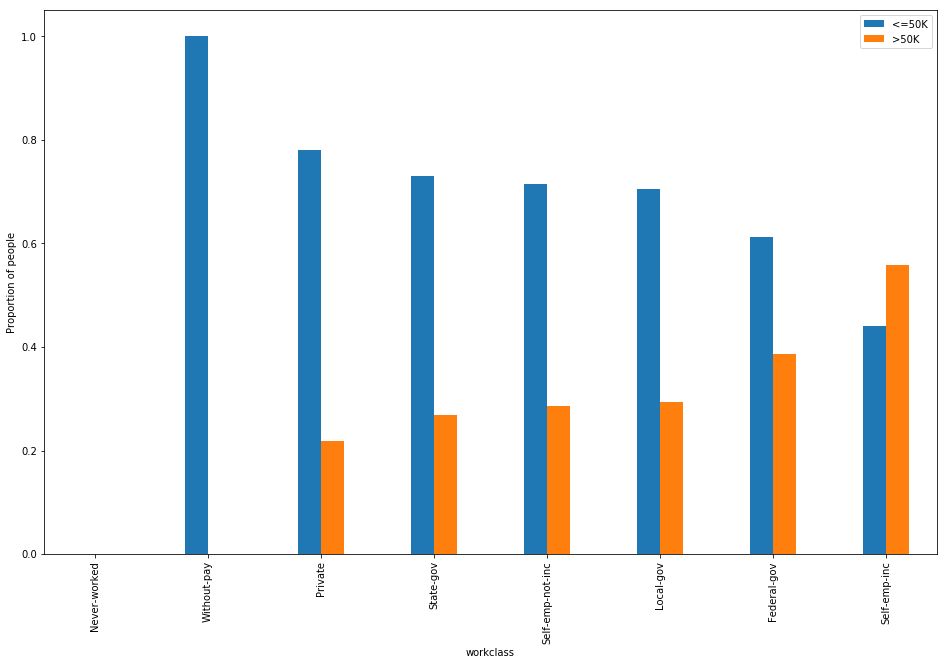

In [28]:
# Counting rows wrt workclass and incomes
work_income_c = train.groupby(['workclass','income']).count()['age']
work_income_c = work_income_c.unstack('income').fillna(0)

# Calculating the proportion of people in each income class for each workclass
sum_in = (work_income_c[class_0] + work_income_c[class_1])

temp = work_income_c[class_0] / sum_in
work_income_c[class_1] = work_income_c[class_1] / sum_in
work_income_c[class_0] = temp

work_income_c = work_income_c.fillna(0).sort_values(by=[class_1])
#print(work_income_c)

fig, axes = plt.subplots()
axes.set_ylabel('Proportion of people')
work_income_c.plot.bar(ax = axes, figsize = (16,10), width = 0.4)
axes.legend(["<=50K",">50K"])
plt.show()

Again, looking at the graph above, we see that people who have better 'sounding' jobs in general have a higher chance of earning more than others.

## 3.2 Education vs Income

C:\Users\Karan\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


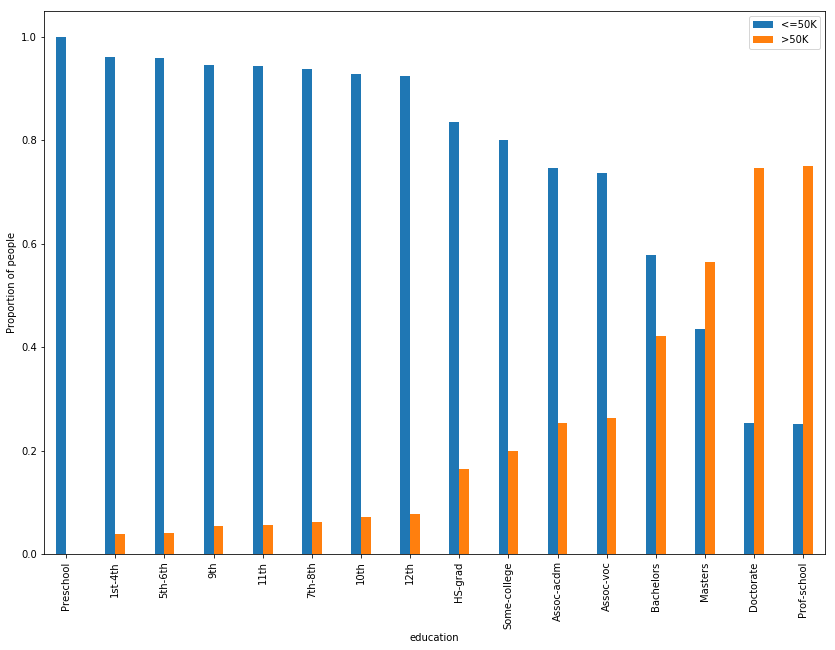

In [29]:
# Counting rows wrt education and incomes
edu_income_c = train.groupby(['education','income']).count()['age']
edu_income_c = edu_income_c.unstack('income').fillna(0)

# Calculating the proportion of people in each income class for each education level
sum_in = (edu_income_c[class_0] + edu_income_c[class_1])

temp = edu_income_c[class_0] / sum_in
edu_income_c[class_1] = edu_income_c[class_1] / sum_in
edu_income_c[class_0] = temp

edu_income_c = edu_income_c.fillna(0).sort_values(by=[class_1])
#print(edu_income_c)

fig, axes = plt.subplots()
axes.set_ylabel('Proportion of people')
edu_income_c.plot.bar(ax = axes, figsize = (14,10), width = 0.4)
axes.legend(["<=50K",">50K"])
fig.show()

We see that, as expected, the proportion of people earning more than 50K increases as people tend to attain higher levels of education. But, not until completing a Masters degree do people earning more than 50K exceed people earning less than 50K.

## 3.3 Occupation vs Income

C:\Users\Karan\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


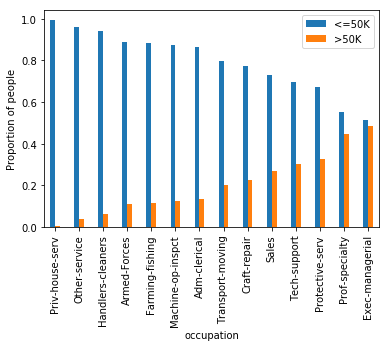

In [30]:
# Counting rows wrt gender and incomes
occ_income_c = train.groupby(['occupation','income']).count()['age']
occ_income_c = occ_income_c.unstack('income').fillna(0)

# Calculating the proportion of people in each income class for each education level
sum_in = (occ_income_c[class_0] + occ_income_c[class_1])

temp = occ_income_c[class_0] / sum_in
occ_income_c[class_1] = occ_income_c[class_1] / sum_in
occ_income_c[class_0] = temp

occ_income_c = occ_income_c.fillna(0).sort_values(by=[class_1])
#print(edu_income_c)

fig, axes = plt.subplots()
axes.set_ylabel('Proportion of people')
occ_income_c.plot.bar(ax = axes, width = 0.4)
axes.legend(["<=50K",">50K"])
fig.show()

## 3.4 Gender vs Income

C:\Users\Karan\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


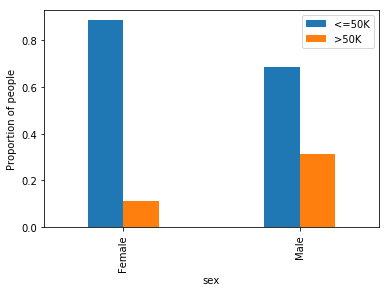

In [31]:
# Counting rows wrt gender and incomes
gender_income_c = train.groupby(['sex','income']).count()['age']
gender_income_c = gender_income_c.unstack('income').fillna(0)

# Calculating the proportion of people in each income class for each education level
sum_in = (gender_income_c[class_0] + gender_income_c[class_1])

temp = gender_income_c[class_0] / sum_in
gender_income_c[class_1] = gender_income_c[class_1] / sum_in
gender_income_c[class_0] = temp

gender_income_c = gender_income_c.fillna(0).sort_values(by=[class_1])
#print(edu_income_c)

fig, axes = plt.subplots()
axes.set_ylabel('Proportion of people')
gender_income_c.plot.bar(ax = axes, width = 0.4)
axes.legend(["<=50K",">50K"])
fig.show()

It can be seen that proportion of men earning more than 50K is almost twice as women earning 50K income

## 3.5 Race vs Income

C:\Users\Karan\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


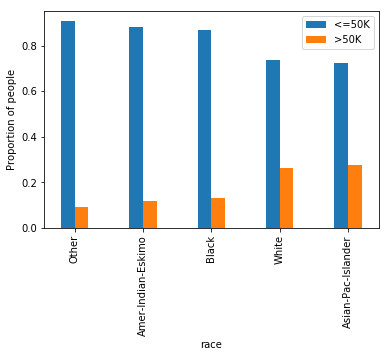

In [32]:
# Counting rows wrt race and incomes
race_income_c = train.groupby(['race','income']).count()['age']
race_income_c = race_income_c.unstack('income').fillna(0)

# Calculating the proportion of people in each income class for each race
sum_in = (race_income_c[class_0] + race_income_c[class_1])

temp = race_income_c[class_0] / sum_in
race_income_c[class_1] = race_income_c[class_1] / sum_in
race_income_c[class_0] = temp

race_income_c = race_income_c.fillna(0).sort_values(by=[class_1])

fig, axes = plt.subplots()
axes.set_ylabel('Proportion of people')
race_income_c.plot.bar(ax = axes, width = 0.4)
axes.legend(["<=50K",">50K"])
fig.show()

This feature is not a great representative of generally how much a person is likely to earn. 

# 4. Model Development


## 4.1 Data preparation

### Feature cleaning

As the education and the education_num is just a one to one mapping, we remove the education_num column from both the training set and the testing set. We do this as the model can be trained wrong thinking there is another feature, but these two features are completely correlated to each other.

In [33]:
train.drop(columns="education_num", inplace=True)
test.drop(columns="education_num", inplace=True)

We also remove the class variable from the train and the test data into separate arrays to be used in each models

In [34]:
train_results = np.copy(train['income'].values)
train.drop(columns="income",inplace=True)

test_results = np.copy(test['income'].values)
test.drop(columns="income",inplace=True)

### One-hot encoding

This is used to convert the categorical columns into binary features. This does increase the dimensionality of the data, but the performance of the different models improves if we use this form of the data.

In [35]:
train_ohe = pd.get_dummies(train)
test_ohe = pd.get_dummies(test)
#print(test_ohe.shape)
test_ohe['country_Holand-Netherlands'] = np.zeros(test_ohe.shape[0])
#print(test_ohe)

#test_ohe['dd'] = test_ohe['age']
#print(set(train_ohe.columns) - set(test_ohe.columns))
#print(len(test_ohe.columns))
#print(np.where(train_ohe.columns != test_ohe.columns))
#print(train_ohe.shape)
#print(test_ohe.shape)

### Normalization of train and test data

In [36]:
data_scaler_obj = StandardScaler()
data_scaler_obj.fit(train_ohe)
train_ohe = data_scaler_obj.transform(train_ohe)
test_ohe = data_scaler_obj.transform(test_ohe)

C:\Users\Karan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Karan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Karan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


### Model evaluator function

In [37]:
def conf_calc(observed, predicted):
    #conf = pd.crosstab(observed, predicted, rownames=['Observed'], colnames=['Predicted'])
    true_positive = true_negative = false_positive = false_negative = 0
    for i in range(len(observed)):
        if observed[i] == -1 and predicted[i] == -1:
            true_negative += 1
        elif observed[i] == 1 and predicted[i] == 1:
            true_positive += 1
        elif observed[i] == 1 and predicted[i] == -1:
            false_negative += 1
        elif observed[i] == -1 and predicted[i] == 1:
            false_positive += 1
    
    accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    try:
        precision = (true_positive)/(true_positive + false_positive)
    except ZeroDivisionError:
        precision = 0
    specificity = (true_positive)/(true_positive + false_negative)
    sensitivity = (true_negative)/(true_negative + false_positive)
    return [accuracy,precision, specificity,sensitivity]

## 4.2 Models

### 4.2.1 Decision Tree

#### k-cross Validation on decision tree to find the best hyperparameters

In order to avoid overfitting the model on the training data, we use k-cross validation and try to find the values of the hyperparameters from the corresponding plots that may not necessarily give the best performance on the validation data, if it is overfitting on the training data. We only consider the max_depth, min_samples_split and the min_samples_leaf hyperparameters in this decision tree.
So, over a range of values of max_depth, min_samples_split and min_samples_leaf, we check the auc for the training and k-cross validation data and looking at the plots, select the hyperparameters.

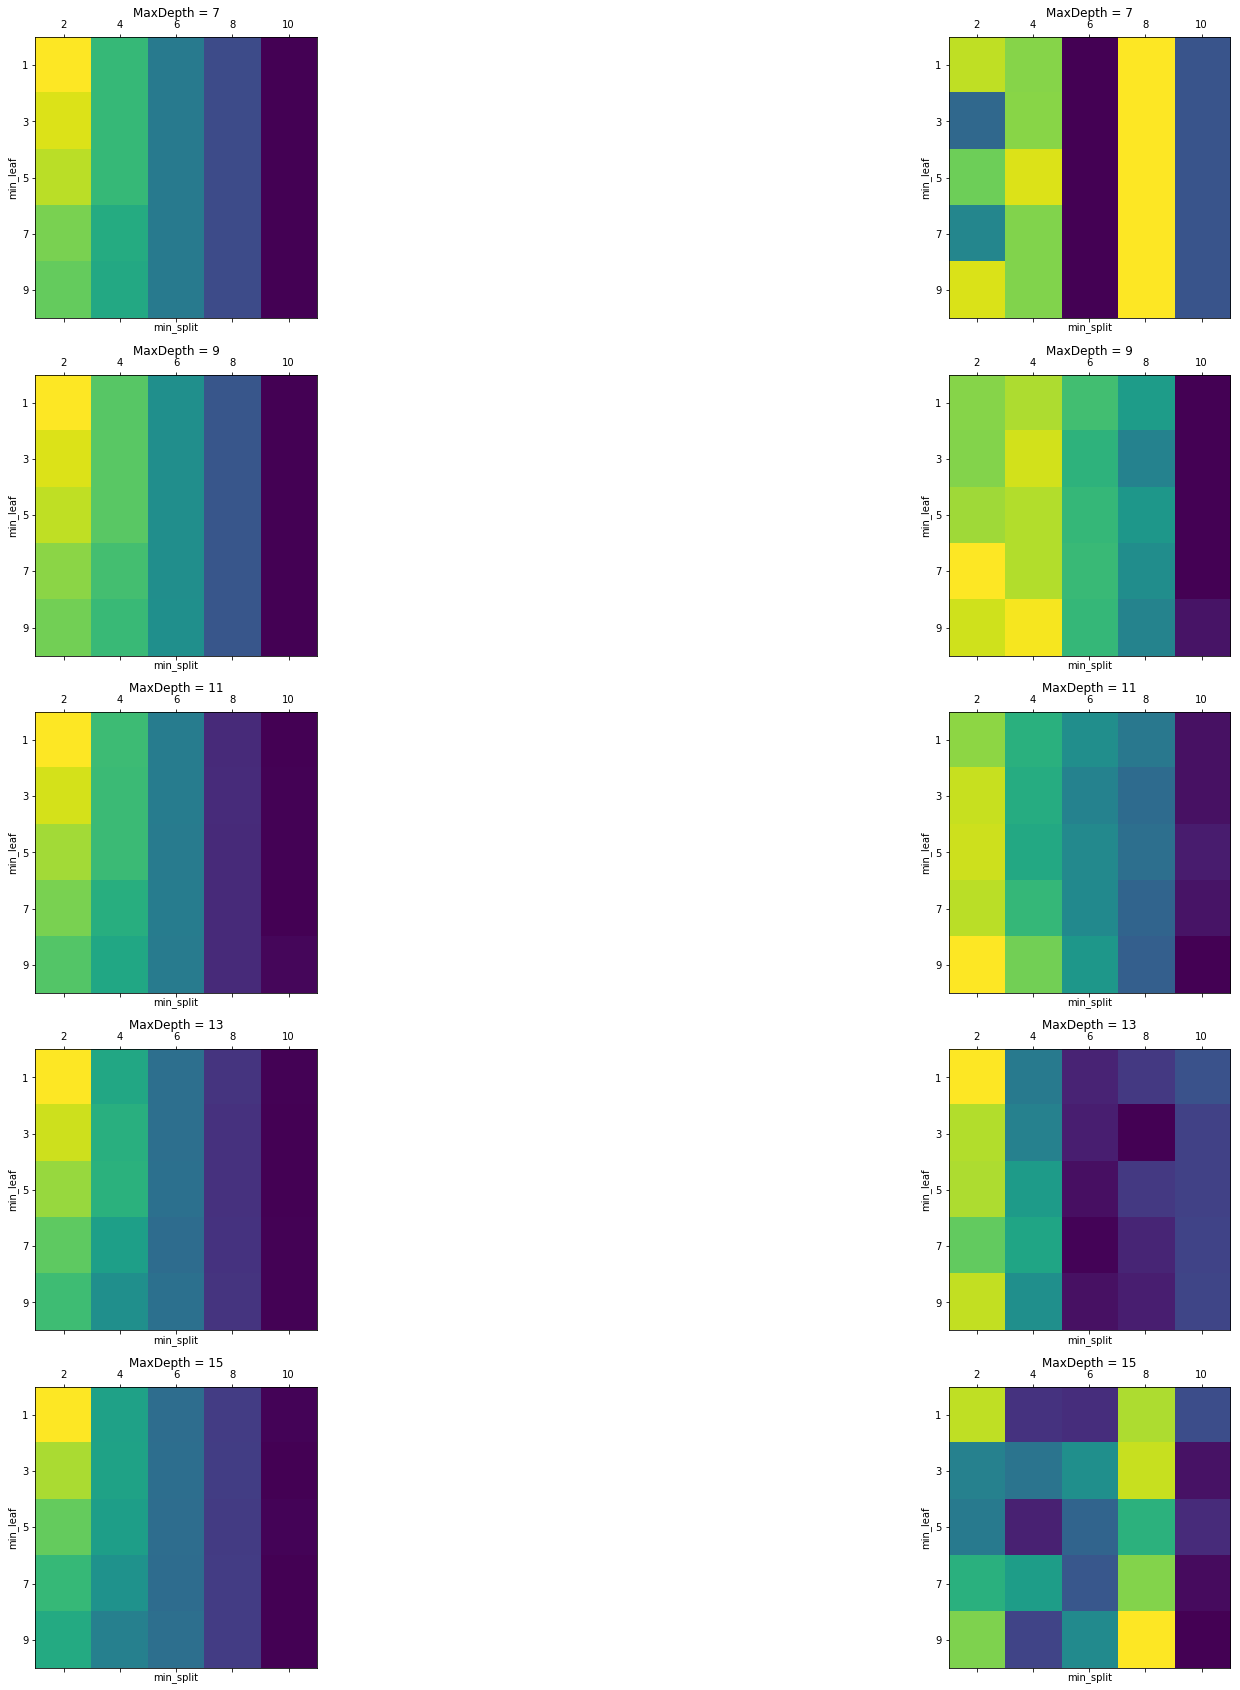

In [38]:
kf = KFold(n_splits = 5, shuffle=False)
fig, axes = plt.subplots(5,2, figsize = (30,30))

d_range = range(7,16,2)
s_range = range(2,11,2)
l_range = range(1,11,2)

for k,d in enumerate(d_range):
    tr_auc = np.zeros((len(s_range),len(l_range)))
    va_auc = np.zeros((len(s_range),len(l_range)))
    for i,s in enumerate(s_range):
        for j,l in enumerate(l_range):
            tr_mean = 0
            va_mean = 0
            for tr_index, va_index in kf.split(train_ohe):
                k_tr = train_ohe[tr_index]
                k_va = train_ohe[va_index]
                k_tr_results = train_results[tr_index]
                k_va_results = train_results[va_index]
                
                dtree_c = tree.DecisionTreeClassifier(criterion = 'entropy', splitter='best', max_depth=d, min_samples_split = s, min_samples_leaf = l)
                dtree_c = dtree_c.fit(k_tr, k_tr_results)
                
                tr_dtree_pred = dtree_c.predict(k_tr)
                tr_false_positive_rate, tr_recall, tr_thresholds = roc_curve(k_tr_results,tr_dtree_pred)
                tr_roc_auc = auc(tr_false_positive_rate, tr_recall)
                #train_out = conf_calc(k_tr_results, dtree_train_pred)
                tr_mean += tr_roc_auc
                
                va_dtree_pred = dtree_c.predict(k_va)
                va_false_positive_rate, va_recall, va_thresholds = roc_curve(k_va_results,va_dtree_pred)
                va_roc_auc = auc(va_false_positive_rate, va_recall)
                #train_out = conf_calc(k_tr_results, dtree_train_pred)
                va_mean += va_roc_auc
                
            tr_auc[i][j] = tr_mean / 5
            va_auc[i][j] = va_mean / 5
            '''
            if (max_mean < c_mean):
                f_l[0] = d
                f_l[1] = s
                f_l[2] = l
                max_mean = c_mean
            '''
    axes[k][0].set_xlabel('min_split')
    axes[k][0].set_ylabel('min_leaf')
    axes[k][0].set_title("MaxDepth = " + str(d))
    cax = axes[k][0].matshow(tr_auc, interpolation='nearest')
    axes[k][0].set_xticklabels([''] + list(s_range))
    axes[k][0].set_yticklabels([''] + list(l_range))
    
    axes[k][1].set_xlabel('min_split')
    axes[k][1].set_ylabel('min_leaf')
    axes[k][1].set_title("MaxDepth = " + str(d))
    cax = axes[k][1].matshow(va_auc, interpolation='nearest')
    axes[k][1].set_xticklabels([''] + list(s_range))
    axes[k][1].set_yticklabels([''] + list(l_range))
#for li in f_l:
#    print(li)

As seen from the plots above, we find two candidate values(where validation auc is great(yellow), given the training auc is not yellow as well) of our ideal hyperparameters
1. max_depth = 9, min_samples_split = 2, min_samples_leaf = 7
2. max_depth = 9, min_samples_split = 4, min_samples_leaf = 9
3. max_depth = 11, min_samples_split = 2, min_samples_leaf = 9

Lets test the performance of the decision tree on the above three hyperparameters

In [39]:
MD = [9,9,11]
MSS = [2,4,2]
MSL = [7,9,9]
acc = [None] * len(MD)
pre = [None] * len(MD)
spe = [None] * len(MD)
sen = [None] * len(MD)
max_acc = -1
max_index = -1
for i in range(0,len(MD),1):
    dtree_c = tree.DecisionTreeClassifier(criterion = 'entropy', splitter='best', max_depth = MD[i], min_samples_split = MSS[i], min_samples_leaf = MSL[i])
    dtree_c = dtree_c.fit(train_ohe, train_results)
    te_dtree_pred = dtree_c.predict(test_ohe)
    acc[i],pre[i],spe[i],sen[i] = conf_calc(test_results, te_dtree_pred)
    if(max_acc < acc[i]):
        max_acc = acc[i]
        max_index = i
print("Max accuracy when \nMax Depth : " + str(MD[max_index]) + "\nMin Split : " + str(MSS[max_index]) + " \nMin Leaf : " + str(MSL[max_index]))

Max accuracy when 
Max Depth : 9
Min Split : 2 
Min Leaf : 7


At the above hyperparameters, let us print the accuracy, precision, specificity and sensitivity for our predictions

In [40]:
eval_dict = {'accuracy': acc[max_index], 'precision' : pre[max_index], 'specificity' : spe[max_index], 'sensitivity' : sen[max_index]}
eval_df = pd.DataFrame([eval_dict], index = ['Entropy'])
print(eval_df)

         accuracy  precision  sensitivity  specificity
Entropy  0.853785   0.766169     0.942077     0.582703


### 4.2.2 kNN classifier